In [42]:
import sympy as sy
from sympy import exp, cosh, sinh
sy.init_printing()

In [43]:
beta, B, C = sy.symbols('beta B C', real=True)
eps, s = sy.symbols('epsilon s', real=True, positive=True)
c = sy.symbols('c', integer=True)
m, i = sy.symbols('m, i', integer=True, positive=True)
one, two, three = sy.Integer(1), sy.Integer(2), sy.Integer(3)

In [44]:
subs0 = (s, (exp(beta) + exp(-beta)) / 2 - 1)
subs1 = (exp(beta*m), cosh(beta*m) + sinh(beta*m))
subs2 = ((cosh(beta*m) + sinh(beta*m))**2,
         (cosh(beta*m) + sinh(beta*m))
         / (cosh(beta*m) - sinh(beta*m)))
subs3 = (exp(beta), cosh(beta) + sinh(beta))
subs4 = ((cosh(beta) + sinh(beta))**2, 
         (cosh(beta) + sinh(beta))
         / (cosh(beta) - sinh(beta)))
subs5 = (i, (c+1)/2 + m)

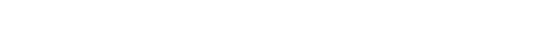

In [45]:
eq1 = (1-eps)/2 * (B * exp(beta) + C * exp(-beta)) - (s + (1-eps)/2) * (B + C)
eq2 = (B * exp((m-2)*beta) + C * exp(-(m-2)*beta)) / 2 - (s + three/2) *  (B * exp((m-1)*beta) + C * exp(-(m-1)*beta))
eq2

In [46]:
sol = sy.linsolve([eq1.subs(*subs0), eq2.subs(*subs0) - 1/s], (B, C))
Bsol, Csol = sol.args[0]


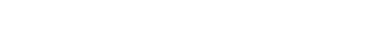

In [47]:
sy.factor(sy.simplify(Bsol))

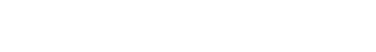

In [48]:
sy.factor(sy.simplify(Csol))

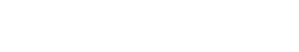

In [49]:
Bcore = sy.factor(Bsol * (exp(beta) + 1))
Ccore = sy.factor(Csol * (exp(beta) + 1))
Bcore

In [50]:
Bsimp = sy.collect(sy.simplify(Bcore.subs([subs1, subs2])), [cosh(beta*m), sinh(beta*m)]).subs([subs3, subs4])
Csimp = sy.collect(sy.simplify(Ccore.subs([subs1, subs2])), [cosh(beta*m), sinh(beta*m)]).subs([subs3, subs4])

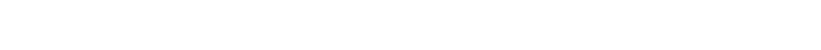

In [51]:
Bfinal = sy.trigsimp(sy.simplify(Bsimp) / (exp(beta) + 1))
Cfinal = sy.trigsimp(sy.simplify(Csimp) / (exp(beta) + 1))
Bfinal, Cfinal

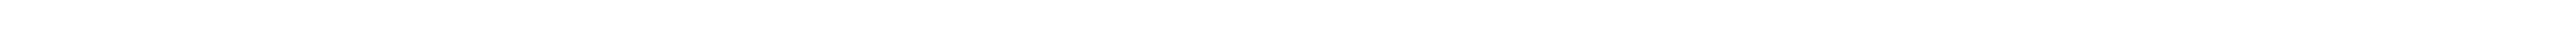

In [52]:
Bser = sy.series(Bfinal.subs(*subs0), beta, 0, 3)
sy.collect(sy.simplify(Bser), beta)

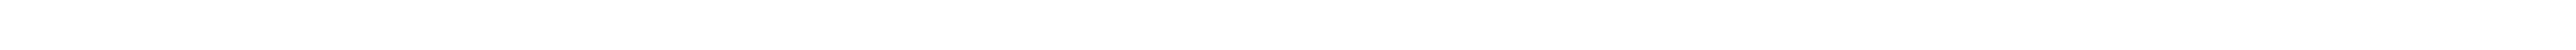

In [53]:
Cser = sy.series(Cfinal.subs(*subs0), beta, 0, 3)
sy.collect(sy.simplify(Cser), beta)

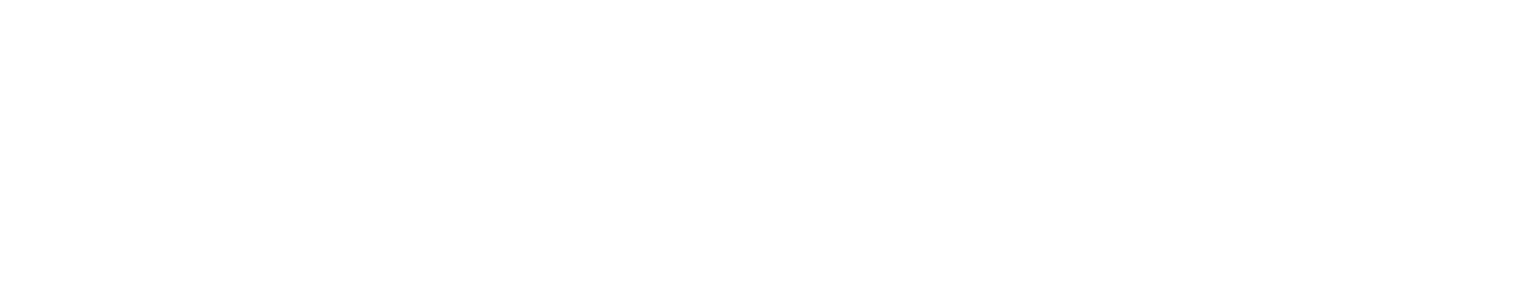

In [54]:
deta = sy.series(1/subs0[1] + Bser * exp(beta*(i-1)) + Cser * exp(-beta*(i-1)), beta, 0, 3)
eta_s = sy.series(sy.simplify(deta), eps, 1, 1)
eta_s

In [60]:
eta_val = eta_s.subs(beta, 0).subs(*subs5)
eta_p_val = sy.diff(eta_s, beta, 2).subs(beta, 0).subs(*subs5)

In [61]:
eta_ser = sy.series(sy.expand(eta_val), eps, 1, 1)
eta_1 = sy.factor(sy.limit((1-eps) * eta_ser, eps, 1)) / (1-eps)
eta_0 = sy.factor(sy.limit((eta_ser - eta_1), eps, 1))
eta = eta_1 + eta_0

In [62]:
eta_p_ser = sy.series(sy.expand(eta_p_val), eps, 1, 1)
eta_p_2 = sy.factor(sy.limit((1-eps)**2 * eta_p_ser, eps, 1)) / (1-eps)**2
eta_p_1 = sy.factor(sy.limit((1-eps) * (eta_p_ser - eta_p_2), eps, 1)) / (1-eps)
eta_p_0 = sy.factor(sy.limit((eta_p_ser - eta_p_2 - eta_p_1), eps, 1))
eta_p = eta_p_2 + eta_p_1 + eta_p_0

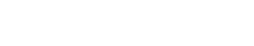

In [63]:
eta

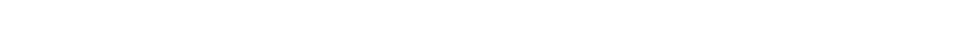

In [64]:
eta_p